There is ztf photometry available. Let's have a look.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
hdul = fits.open('ztf/ztflc1.fits')

In [3]:
hdul[1].data.names

['null_bitfield_flags',
 'oid',
 'expid',
 'hjd',
 'mjd',
 'mag',
 'magerr',
 'catflags',
 'filtercode',
 'ra',
 'dec',
 'chi',
 'sharp',
 'filefracday',
 'field',
 'ccdid',
 'qid',
 'limitmag',
 'magzp',
 'magzprms',
 'clrcoeff',
 'clrcounc',
 'exptime',
 'airmass',
 'programid']

In [6]:
#hdul[1].header

In [10]:
#catflags is the data qualiy.  32768 = cloud
data = hdul[1].data
data['catflags']

array([    0,     0,     0,     0, 32768,     0, 32768,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 32768,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 32768,     0,     0,     0,
           0,     0,     0,     0,     0,     0, 32768,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 32768,     0, 32768,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 32768, 32768,     0, 32768,
           0,     0,     0,     0, 32768, 65535,     0,     0,     0,
           0], dtype=int32)

In [11]:
dataq = data[data['catflags'] ==0]
gdata = dataq[dataq['filtercode'] == 'zg']
rdata = dataq[dataq['filtercode'] == 'zr']

(17.2, 17.9)

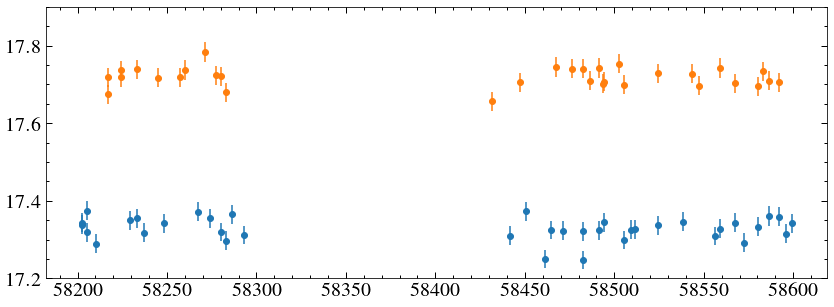

In [14]:
plt.errorbar(gdata['mjd'], gdata['mag'], yerr=gdata['magerr'], marker='o', ls='none')
plt.errorbar(rdata['mjd'], rdata['mag'], yerr=rdata['magerr'], marker='o', ls='none')
plt.ylim(17.2, 17.9)

In [15]:
period = 4.23*u.h

1.1420210653982268 h
1.662277113134937 h


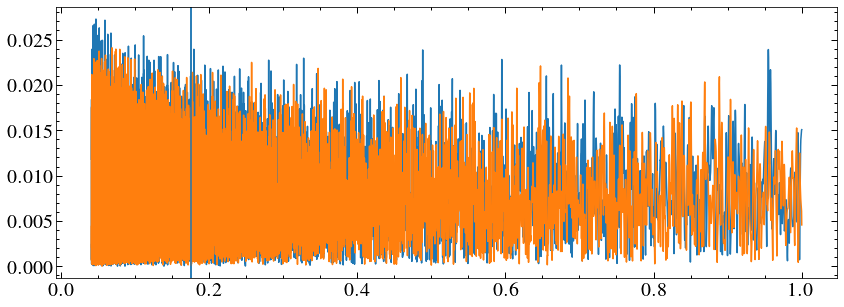

In [26]:
for band in [gdata, rdata]:
    lc = lk.LightCurve(time= band['mjd']*u.d, flux=band['mag'], flux_err=band['magerr'])
    lcfold = lc.fold(period)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=1*u.h, maximum_period=1*u.day)
    plt.plot(pg.period, pg.power)
    print(pg.period_at_max_power.to(u.h))
    plt.axvline(4.23/24)    

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the sa

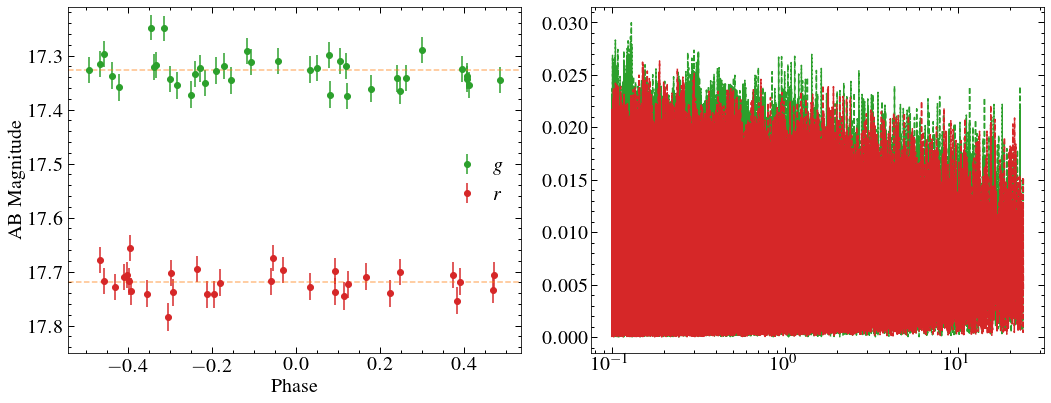

In [106]:
plt.figure(figsize=(15,6))
bands = ['$g$', '$r$']
cols = ['C2', 'C3']
for i, bandat in enumerate([gdata, rdata]):
    plt.subplot(121)
    lc = lk.LightCurve(time= bandat['mjd']*u.d, flux=bandat['mag'], flux_err=bandat['magerr'])
    lcfold = lc.fold(period)
    plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none', label= bands[i], color=cols[i])
    plt.axhline(np.median(lc.flux), ls='--', c='C1', alpha=0.5)
    plt.subplot(122)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.h, maximum_period=1*u.day)
    plt.plot(pg.period*24, pg.power, ls='--', c=cols[i])
    
plt.subplot(121)    
plt.ylim(17.85, 17.21)
plt.xlabel('Phase')
plt.ylabel('AB Magnitude')
plt.legend()
plt.subplot(122)
plt.xscale('log')
#plt.yscale('log')
#[plt.axvline(line, ls='--') for line in [-0.03, 0.03]]
plt.tight_layout()
#plt.savefig('plots/ztf_folded.pdf')

In [92]:
#ecclipse duration
P = period
a = 0.7*u.Rsun
R1 = 0.0131*u.Rsun
R2 = 0.11*u.Rsun
tdur = (P/np.pi)*np.arcsin((R1+R2)/a)
tdur
tdur.value*60

14.281244748454043

In [61]:
tdur/period

<Quantity 0.05626968 rad>

In [86]:
P = 0.93*u.d
a = 0.6*u.Rsun
R1 = 0.0131*u.Rsun
R2 = 0.396*u.Rsun
tdur = (P/np.pi)*np.arcsin((R1+R2)/a)
tdur.value*60

13.325992574349597